In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

import tensorflow as tf
# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

In [2]:
import glob
uav_path = '../data/phantom/JUNE_01_PHANTOMS/wavs/*.wav'
none_path = '../data/phantom/JUNE_02_BACKGROUND/wavs/background/background_0*.wav'
uav_files = glob.glob(uav_path)
none_files = glob.glob(none_path)

In [3]:
print(len(uav_files),'개\t', uav_files[0])
print(len(none_files), '개\t',none_files[0])

11 개	 ../data/phantom/JUNE_01_PHANTOMS/wavs\P1_stationary.wav
21 개	 ../data/phantom/JUNE_02_BACKGROUND/wavs/background\background_06_02_01.wav


# Load Data

The reason of why SR is 44100 is that the sample rate of above files is 44.1kbps

a wav file sample has 884736. if sample is divided by sample rate, the value is time
the time is fixed by 20.06

In [4]:
def loadSample(files,sample_rate):
    [sample_np, sample_rate] = librosa.load(files[0],sample_rate)
    print(len(sample_np), sample_rate, files[0])
    for f in files[1:]:
        [sample, sample_rate] = librosa.load(f,sample_rate)
        sample_np = np.hstack((sample_np, sample))
    return sample_np, sample_rate

In [5]:
SR = 44100
uav_sample, uav_sample_rate = loadSample(uav_files,SR )
none_sample, none_sample_rate = loadSample(none_files,SR)

print(uav_sample.shape,none_sample.shape )
combine = [[uav_sample,uav_path,uav_sample_rate],[none_sample,none_path,none_sample_rate]]

884736 44100 ../data/phantom/JUNE_01_PHANTOMS/wavs\P1_stationary.wav
884736 44100 ../data/phantom/JUNE_02_BACKGROUND/wavs/background\background_06_02_01.wav
(9732096,) (18579456,)


# Feature extraction 
## steps
#### 1. Resampling 
#### 2. *VAD*( Voice Activity Detection)
#### 3. Maybe padding with 0 to make signals be equal length
#### 4. Log spectrogram (or *MFCC*, or *PLP*)
#### 5. Features normalization with *mean* and *std*
#### 6. Stacking of a given number of frames to get temporal information



## 1. Resampling

if you see the graph, there are few at high frequency. this is mean that data is big but it's no useless. so To small the data, do Resampling. In general, use 0~8000Hz 

In [6]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [7]:
def showFreqTime(combine):
    for sample, filename, _ in combine:
        freqs, times, spectrogram = log_specgram(sample, SR)
        fig = plt.figure(figsize=(14, 10))
        ax1 = fig.add_subplot(211)
        ax1.set_title('Raw wave of ' + filename)
        ax1.set_ylabel('Amplitude')
        ax1.plot(np.linspace(0, len(sample)/SR, len(sample)), sample)

        ax2 = fig.add_subplot(212)
        ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
        ax2.set_yticks(freqs[::16])
        ax2.set_xticks(times[::16])
        ax2.set_title('Spectrogram of ' + filename)
        ax2.set_ylabel('Freqs in Hz')
        ax2.set_xlabel('Seconds')

In [8]:
#showFreqTime(combine)

In [9]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

In [10]:
new_sample_rate = combine[0][2]  #/4
combine_prev = combine[:]

combine = []
for samples, path, sample_rate in combine_prev:
    resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))
    combine.append([resampled,path,new_sample_rate])

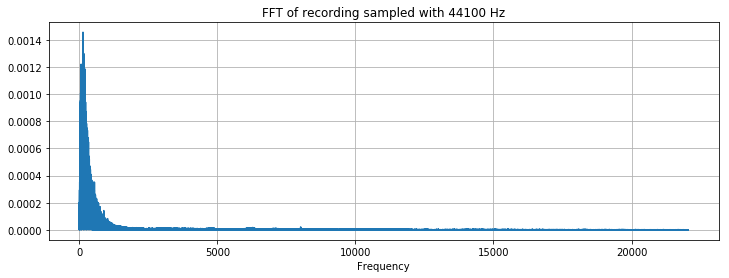

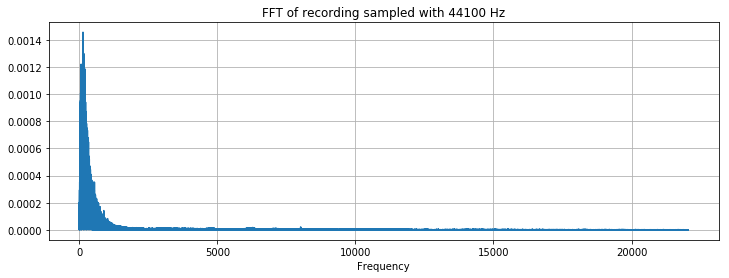

In [11]:
for samples, path, sample_rate in [combine_prev[0],combine[0]]:
    xf, vals = custom_fft(samples, sample_rate)
    plt.figure(figsize=(12, 4))
    plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
    plt.plot(xf, vals)
    plt.xlabel('Frequency')
    plt.grid()
    plt.show()

### Data diffrence

qualiy is diffrence but, the data is almost same.

In [12]:
#ipd.Audio(combine_prev[0][0], rate=combine_prev[0][2])

In [13]:
#ipd.Audio(combine[0][0], rate=combine[0][2])

## 2. VAD

Sometimes, Files have silence. It is not necessary. So, We need to find sound of Drone except silence.

But, Not yet implemented

## 3. padding with 0 to make signals be equal length

If we have a lot of sound files, we need to pad some datas. But These files's time is longger than 1 second. So It dosn't need to pad

## 4. Log spectrogram (or MFCC, or PLP)

The upper picture is resampled data. 
The lower picture is original data.

In MFCC Feature, There is no big difference. 

In [14]:
from scipy.stats import skew
#returns mfcc features with mean and standard deviation along time
def get_mfcc(b):
    ft1 = librosa.feature.mfcc(b, sr = SR, n_mfcc=20)
    ft2 = librosa.feature.zero_crossing_rate(b)[0]
    ft3 = librosa.feature.spectral_rolloff(b)[0]
    ft4 = librosa.feature.spectral_centroid(b)[0]
    ft5 = librosa.feature.spectral_contrast(b)[0]
    ft6 = librosa.feature.spectral_bandwidth(b)[0]
    ft1_trunc = np.hstack((np.mean(ft1, axis=1), np.std(ft1, axis=1), skew(ft1, axis = 1), np.max(ft1, axis = 1), np.min(ft1, axis = 1)))
    ft2_trunc = np.hstack((np.mean(ft2), np.std(ft2), skew(ft2), np.max(ft2), np.min(ft2)))
    ft3_trunc = np.hstack((np.mean(ft3), np.std(ft3), skew(ft3), np.max(ft3), np.min(ft3)))
    ft4_trunc = np.hstack((np.mean(ft4), np.std(ft4), skew(ft4), np.max(ft4), np.min(ft4)))
    ft5_trunc = np.hstack((np.mean(ft5), np.std(ft5), skew(ft5), np.max(ft5), np.min(ft5)))
    ft6_trunc = np.hstack((np.mean(ft6), np.std(ft6), skew(ft6), np.max(ft6), np.min(ft6)))
    #print(len(ft1_trunc),len(ft2_trunc),len(ft3_trunc),len(ft4_trunc),len(ft5_trunc),len(ft6_trunc))
    return pd.Series(np.hstack((ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc, ft6_trunc)))
def mfcc(raw, chunk_size=8192, sr=44100, n_mfcc=13):
    mfcc = np.empty((13, 0))
    for i in range(0, len(raw), chunk_size):
        mfcc_slice = librosa.feature.mfcc(raw[i:i+chunk_size], sr=sr, n_mfcc=n_mfcc)
        mfcc = np.hstack((mfcc, mfcc_slice))
    return mfcc
def mfcc2(raw, label, chunk_size=8192, sr=44100, n_mfcc=13):
    mfcc = np.empty((0, n_mfcc, 17))
    y = []
    for i in range(0, len(raw), chunk_size):
        mfcc_slice = librosa.feature.mfcc(raw[i:i+chunk_size], sr=sr, n_mfcc=n_mfcc)
        mfcc_slice = mfcc_slice.reshape((1,n_mfcc,17))
        mfcc = np.vstack((mfcc, mfcc_slice))
        y.append(label)
    y = np.array(y)
    return mfcc, y
def mfcc3(raw, label, chunk_size=8192, sr=44100, n_mfcc=13):
    mfcc = np.empty((n_mfcc*17, 0))
    y = []
    for i in range(0, len(raw), chunk_size):
        mfcc_slice = librosa.feature.mfcc(raw[i:i+chunk_size], sr=sr, n_mfcc=n_mfcc)
        #print(mfcc_slice)
        mfcc_slice = mfcc_slice.reshape((n_mfcc*17, 1)) #mfcc_slice.reshape((1,n_mfcc,17))
        #print(mfcc_slice)
        mfcc = np.hstaack((mfcc, mfcc_slice))
        y.append(label)
    y = np.array(y)
    return mfcc, y
def mfcc4(raw, label, chunk_size=8192, window_size=4096, sr=44100, n_mfcc=16, n_frame=16):
    mfcc = np.empty((0, n_mfcc, n_frame))
    y = []
    print(raw.shape)
    for i in range(0, len(raw), chunk_size//2):
        mfcc_slice = librosa.feature.mfcc(raw[i:i+chunk_size], sr=sr, n_mfcc=n_mfcc) #n_mfcc,17
        if mfcc_slice.shape[1] < 17:
            print("small end:", mfcc_slice.shape)
            continue
        mfcc_slice = mfcc_slice[:,:-1]
        mfcc_slice = mfcc_slice.reshape((1, mfcc_slice.shape[0], mfcc_slice.shape[1]))
        mfcc = np.vstack((mfcc, mfcc_slice))
        y.append(label)
    y = np.array(y)
    return mfcc, y

def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [15]:
spectro_combine = []
for sample,path,sample_rate in combine:
    freqs, times, spectrogram = log_specgram(sample, sample_rate)
    spectro_combine.append([freqs, times, spectrogram ])
spectro_combine_tmp = spectro_combine

In [16]:
'''
mfcc_combine = []
framesize = 8192
for sample,path,sample_rate in combine:
    #sample = sample[:8192*1] 
    _mfcc = mfcc(sample)
    mfcc_combine.append(_mfcc.T)
'''


'\nmfcc_combine = []\nframesize = 8192\nfor sample,path,sample_rate in combine:\n    #sample = sample[:8192*1] \n    _mfcc = mfcc(sample)\n    mfcc_combine.append(_mfcc.T)\n'

In [17]:
'''
mfcc_combine = []
framesize = 8192
for sample,path,sample_rate in combine:
    #sample = sample[:8192*1] 
    _mfccs = np.zeros(shape=[0,20],dtype=float)
    for i in range(0,int(len(sample)),framesize):
        S = librosa.feature.melspectrogram(sample[i:i+framesize], sr=sample_rate, n_mels=128)
        log_S = librosa.power_to_db(S, ref=np.max)
        mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=20)
        delta2_mfcc = librosa.feature.delta(mfcc, order=2)
        delta2_mfcc = delta2_mfcc.T 
        _mfccs = np.vstack((_mfccs,delta2_mfcc[:]))
    print(_mfccs.shape)
    mfcc_combine.append(_mfccs)
'''

'\nmfcc_combine = []\nframesize = 8192\nfor sample,path,sample_rate in combine:\n    #sample = sample[:8192*1] \n    _mfccs = np.zeros(shape=[0,20],dtype=float)\n    for i in range(0,int(len(sample)),framesize):\n        S = librosa.feature.melspectrogram(sample[i:i+framesize], sr=sample_rate, n_mels=128)\n        log_S = librosa.power_to_db(S, ref=np.max)\n        mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=20)\n        delta2_mfcc = librosa.feature.delta(mfcc, order=2)\n        delta2_mfcc = delta2_mfcc.T \n        _mfccs = np.vstack((_mfccs,delta2_mfcc[:]))\n    print(_mfccs.shape)\n    mfcc_combine.append(_mfccs)\n'

In [18]:
'''
mfcc_combine = []
framesize = 4096
_mfccs = np.zeros(shape=[0, 125],dtype=float)
for sample,path,sample_rate in combine:
    for i in range(0,int(len(sample)),framesize):
        _mfccs = np.vstack((_mfccs,get_mfcc(sample[i:i+framesize])))
    mfcc_combine.append(_mfccs)
    print(_mfccs.shape)
'''

'\nmfcc_combine = []\nframesize = 4096\n_mfccs = np.zeros(shape=[0, 125],dtype=float)\nfor sample,path,sample_rate in combine:\n    for i in range(0,int(len(sample)),framesize):\n        _mfccs = np.vstack((_mfccs,get_mfcc(sample[i:i+framesize])))\n    mfcc_combine.append(_mfccs)\n    print(_mfccs.shape)\n'

In [19]:
'''
mfcc_combine = []

#_mfccs = np.zeros(shape=[20, 0],dtype=float)
#np.vstack  Stack arrays in sequence vertically
#np.hstack  Split array along second axis.

'''
'''

mfcc_uav , y_uav = mfcc4(combine[0][0], 1)
print(mfcc_uav.shape, y_uav.shape)
mfcc_none, y_none = mfcc4(combine[1][0], 0)
print(mfcc_none.shape, y_none.shape)
'''
'''
for sample,path,sample_rate in combine:
    mfcc_uav, y_uav = mfcc4(uav_raw, 1)
    
    mfcc_none, y_none = mfcc4(none_raw, 0)
    mfcc_combine.append(_mfcc)
'''

'\nfor sample,path,sample_rate in combine:\n    mfcc_uav, y_uav = mfcc4(uav_raw, 1)\n    \n    mfcc_none, y_none = mfcc4(none_raw, 0)\n    mfcc_combine.append(_mfcc)\n'

In [20]:
'''
mfcc_combine = []
for sample,path,sample_rate in combine:
    S = librosa.feature.melspectrogram(sample, sr=sample_rate, n_mels=128)
    # Convert to log scale (dB). We'll use the peak power (max) as reference.
    log_S = librosa.power_to_db(S, ref=np.max)
    mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

    # Let's pad on the first and second deltas while we're at it
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    mfcc_combine.append(delta2_mfcc)
    
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(delta2_mfcc[ : ,int(delta2_mfcc.shape[1]*0.025) :int(delta2_mfcc.shape[1]*0.030)])
    plt.ylabel('MFCC coeffs')
    plt.xlabel('Time')
    plt.title('MFCC'+path)
    plt.colorbar()
    plt.tight_layout()
    print(delta2_mfcc.shape , sample_rate,int(delta2_mfcc.shape[1]*0.01))
'''

"\nmfcc_combine = []\nfor sample,path,sample_rate in combine:\n    S = librosa.feature.melspectrogram(sample, sr=sample_rate, n_mels=128)\n    # Convert to log scale (dB). We'll use the peak power (max) as reference.\n    log_S = librosa.power_to_db(S, ref=np.max)\n    mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)\n\n    # Let's pad on the first and second deltas while we're at it\n    delta2_mfcc = librosa.feature.delta(mfcc, order=2)\n    mfcc_combine.append(delta2_mfcc)\n    \n    plt.figure(figsize=(12, 4))\n    librosa.display.specshow(delta2_mfcc[ : ,int(delta2_mfcc.shape[1]*0.025) :int(delta2_mfcc.shape[1]*0.030)])\n    plt.ylabel('MFCC coeffs')\n    plt.xlabel('Time')\n    plt.title('MFCC'+path)\n    plt.colorbar()\n    plt.tight_layout()\n    print(delta2_mfcc.shape , sample_rate,int(delta2_mfcc.shape[1]*0.01))\n"

In [21]:
'''
for sample,path,sample_rate in combine_prev:
    S = librosa.feature.melspectrogram(sample, sr=sample_rate, n_mels=128)
    # Convert to log scale (dB). We'll use the peak power (max) as reference.
    log_S = librosa.power_to_db(S, ref=np.max)
    mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

    # Let's pad on the first and second deltas while we're at it
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(delta2_mfcc[ : ,int(delta2_mfcc.shape[1]*0.025) :int(delta2_mfcc.shape[1]*0.030)])
    plt.ylabel('MFCC coeffs')
    plt.xlabel('Time')
    plt.title('MFCC'+path)
    plt.colorbar()
    plt.tight_layout()
    print(delta2_mfcc.shape , sample_rate,int(delta2_mfcc.shape[1]*0.01))
'''

"\nfor sample,path,sample_rate in combine_prev:\n    S = librosa.feature.melspectrogram(sample, sr=sample_rate, n_mels=128)\n    # Convert to log scale (dB). We'll use the peak power (max) as reference.\n    log_S = librosa.power_to_db(S, ref=np.max)\n    mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)\n\n    # Let's pad on the first and second deltas while we're at it\n    delta2_mfcc = librosa.feature.delta(mfcc, order=2)\n    \n    plt.figure(figsize=(12, 4))\n    librosa.display.specshow(delta2_mfcc[ : ,int(delta2_mfcc.shape[1]*0.025) :int(delta2_mfcc.shape[1]*0.030)])\n    plt.ylabel('MFCC coeffs')\n    plt.xlabel('Time')\n    plt.title('MFCC'+path)\n    plt.colorbar()\n    plt.tight_layout()\n    print(delta2_mfcc.shape , sample_rate,int(delta2_mfcc.shape[1]*0.01))\n"

## 5. Features normalization with *mean* and *std*

In [22]:
spectrogram1 = spectro_combine[0][2]
spectrogram2 = spectro_combine[1][2]
spec = np.vstack((spectrogram1,spectrogram2))

mean = np.mean(spec, axis=0)
std = np.std(spec, axis=0)
spectro_combine[0][2] = (spectro_combine[0][2] - mean) / std
spectro_combine[1][2] = (spectro_combine[1][2] - mean) / std
print(mean, std)

[-14.783377 -13.237326 -13.790195 -14.974861 -16.02743  -16.886328
 -17.562525 -17.916958 -18.162004 -18.151894 -18.028067 -18.147076
 -18.77185  -19.649254 -20.501747 -21.223238 -21.653889 -21.794428
 -21.709572 -21.606184 -21.623947 -21.668095 -21.676298 -21.594275
 -21.55152  -21.501865 -21.437368 -21.418602 -21.42194  -21.493652
 -21.619452 -21.76638  -21.914585 -22.061201 -22.174974 -22.262684
 -22.304296 -22.279842 -22.19678  -22.1155   -22.0866   -22.11853
 -22.190512 -22.277575 -22.391571 -22.531631 -22.667282 -22.776754
 -22.859852 -22.917439 -22.933397 -22.892088 -22.836386 -22.770657
 -22.682306 -22.592741 -22.525318 -22.491041 -22.493334 -22.51041
 -22.531391 -22.552753 -22.568363 -22.573317 -22.576105 -22.577608
 -22.586645 -22.585169 -22.57003  -22.571081 -22.589912 -22.610256
 -22.640768 -22.66337  -22.659088 -22.639498 -22.651543 -22.661533
 -22.662224 -22.665829 -22.669947 -22.678707 -22.679981 -22.686583
 -22.695452 -22.702993 -22.712639 -22.720493 -22.724628 -22.7243

## 6. Stacking of a given number of frames to get temporal information

In [23]:
# or should we give one label to one chunk?
y_uav = np.ones(shape = [len(spectro_combine[0][1])], dtype=int)
y_none =np.zeros(shape =[len(spectro_combine[1][1])], dtype=int)

print(y_uav.shape)
print(y_none.shape)

(22067,)
(42129,)


In [24]:
dataX = np.vstack((spectro_combine[0][2], spectro_combine[1][2]))
dataY = np.hstack((y_uav, y_none))
print(dataX.shape, dataY.shape)

(64196, 442) (64196,)


In [25]:
seq_length = 9 #layer
X_hot_list= []
#Y_hot = dataY[seq_length-1:].reshape(len(dataY[seq_length-1:]), 1)
Y_hot_tmp = dataY[seq_length-1:]

for i in range(0, dataX.shape[0] - seq_length+1):
    _x = dataX[i:i + seq_length]
    #if i<10:
        #print(_x, "->", Y_hot_tmp[i])
    X_hot_list.append(_x)

X_hot = np.array(X_hot_list[:])
print(X_hot.shape, Y_hot_tmp.shape)


(64188, 9, 442) (64188,)


In [26]:
Y_hot_tmp.shape

(64188,)

In [27]:
Y_hot = Y_hot_tmp.reshape((len(Y_hot_tmp),1))
print(Y_hot.shape)

(64188, 1)


In [28]:
from sklearn import model_selection
train_size = int(len(Y_hot) * 0.7)
test_size = len(Y_hot) - train_size
X_train, X_test = np.array(X_hot[0:train_size]),np.array(X_hot[train_size:len(X_hot)])
y_train, y_test = np.array(Y_hot[0:train_size]),np.array(Y_hot[train_size:len(Y_hot)])
#X_train, X_test, y_train, y_test = model_selection.train_test_split(X_hot, Y_hot, test_size=0.2, random_state=42)

In [29]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(44931, 9, 442) (19257, 9, 442)
(44931, 1) (19257, 1)


In [30]:
np.save('../data/Xy/X_train2', X_train)
np.save('../data/Xy/X_test2', X_test)
np.save('../data/Xy/y_train2', y_train)
np.save('../data/Xy/y_test2', y_test)

"\nnp.save('../data/Xy/X_train2', X_train)\nnp.save('../data/Xy/X_test2', X_test)\nnp.save('../data/Xy/y_train2', y_train)\nnp.save('../data/Xy/y_test2', y_test)\n"

In [31]:
X_train = np.load('../data/Xy/X_train2.npy')
X_test = np.load('../data/Xy/X_test2.npy')
y_train = np.load('../data/Xy/y_train2.npy')
y_test = np.load('../data/Xy/y_test2.npy')

"\nX_train = np.load('../data/Xy/X_train2.npy')\nX_test = np.load('../data/Xy/X_test2.npy')\ny_train = np.load('../data/Xy/y_train2.npy')\ny_test = np.load('../data/Xy/y_test2.npy')\n"

# Tensorflow RNN

## Train 

In [32]:
learning_rate = 0.01

# train Parameters
X_dim = 442 #n_dim #X_hot.shape[2]

#seq_length = #X_hot.shape[1]
output_dim = 1 #n_classes #Y_hot.shape[1]

hidden_dim = 2

In [33]:
# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, X_dim], name = 'X')
Y = tf.placeholder(tf.float32, [None, output_dim], name = 'Y')

#X_one_hot = tf.one_hot(X, )
# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
#cell = tf.contrib.rnn.MultiRNNCell([cell]*2, state_is_tuple=True)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
#loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Y_pred, labels = Y))

# optimizer
lr = tf.placeholder(tf.float32,shape=(), name='learning_rate')
train = tf.train.AdamOptimizer(lr).minimize(loss) #AdamOptimizer

# RMSE
targets = tf.placeholder(tf.float32, [None, output_dim] , name = 'targets')
predictions = tf.placeholder(tf.float32, [None, output_dim] , name = 'predictions')
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

In [34]:
X_train[0]

array([[ 1.5071255 ,  1.1629285 ,  0.22309478, ..., -0.23874724,
        -0.22733629, -0.24696735],
       [ 1.071844  ,  0.91408926,  0.9089566 , ..., -0.18009135,
        -0.2089148 , -0.21966761],
       [-2.4098163 ,  0.5119591 ,  1.3657184 , ..., -0.18078455,
        -0.21465859, -0.25918874],
       ...,
       [-0.7270953 ,  0.47982168,  1.3121564 , ...,  0.03224296,
        -0.17400368, -0.25839514],
       [ 1.4379464 ,  1.2411757 ,  1.1558251 , ..., -0.0938672 ,
        -0.15032138, -0.24989232],
       [ 0.41018704,  1.2694248 ,  1.8165795 , ..., -0.05716283,
        -0.21795307, -0.25565156]], dtype=float32)

In [43]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
cost_history = np.empty(shape=[1],dtype=float)
step_loss = 999999.0
model_path = '../models/RNN/my_RNN_model_S27_100'
saver = tf.train.Saver()
training_epochs = 5
# Training step
for learning_rate in [0.02, 0.015, 0.01, 0.005]:
    test_acc = []
    feed = {lr:learning_rate, X: X_train, Y: y_train}
    for i in range(training_epochs):
        step_loss_prev = step_loss
        _, step_loss = sess.run([train, loss], feed_dict=feed)
        cost_history = np.append(cost_history,step_loss/X_train.shape[0])
        
        print("[step: {}] loss: {}".format(i, step_loss/X_train.shape[0]))
        #batch_acc, test_state = sess.run([loss, _states], feed_dict=feed)
    print("Test accuracy: {:.3f}".format(1.0-np.mean(cost_history)))

saver.save(sess, model_path)
sess.close()

c:\users\jh\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\client\session.py:1711: UserWarning:

An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).



[step: 0] loss: 0.5423646987881419
[step: 1] loss: 0.3994923292103448
[step: 2] loss: 0.3490249937056264
[step: 3] loss: 0.30137184742299306
[step: 4] loss: 0.2555622179703323
Test accuracy: 0.564
[step: 0] loss: 0.21629847623995682
[step: 1] loss: 0.18640265768623
[step: 2] loss: 0.16039200645851417
[step: 3] loss: 0.13760229878522068
[step: 4] loss: 0.12200707534539071
Test accuracy: 0.688
[step: 0] loss: 0.1045491433218435
[step: 1] loss: 0.09581949266653313
[step: 2] loss: 0.08938268061374663
[step: 3] loss: 0.08279175312736474
[step: 4] loss: 0.07644634098673522
Test accuracy: 0.757
[step: 0] loss: 0.07167176736968908
[step: 1] loss: 0.06971342603798046
[step: 2] loss: 0.0675684650057171
[step: 3] loss: 0.06521227514132781
[step: 4] loss: 0.06289817998709132
Test accuracy: 0.799


In [44]:
sess = tf.InteractiveSession()
saver.restore(sess, model_path)

# Test step
test_predict = sess.run(Y_pred, feed_dict={X: X_train})
rmse_val = sess.run(rmse, feed_dict={
                    targets: y_train, predictions: test_predict})
print("RMSE: {}".format(rmse_val))

y_pred = sess.run(Y_pred,feed_dict={X: X_test})
y_pred[y_pred<0.5] = 0
y_pred[y_pred>=0.5] = 1
print(y_pred)
y_true = y_test
print(y_pred.shape, y_true.shape)

INFO:tensorflow:Restoring parameters from ../models/RNN/my_RNN_model_S27_100


c:\users\jh\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\client\session.py:1711: UserWarning:

An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).



RMSE: 0.24658635258674622
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
(19257, 1) (19257, 1)


In [45]:
sess.close()

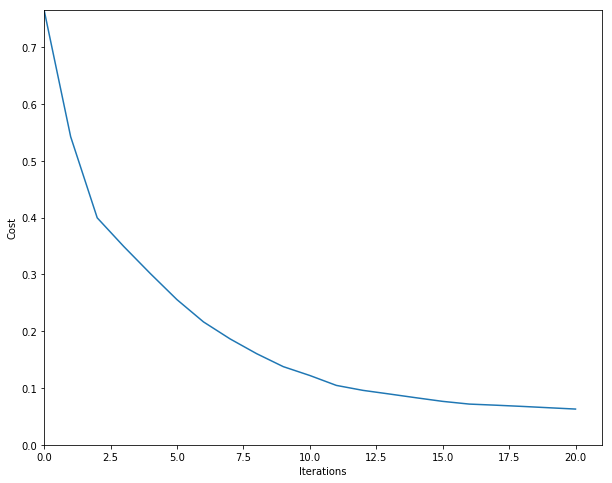

F-Score: 0.966
Accuracy:  0.9664537570753492
             precision    recall  f1-score   support

        0.0       1.00      0.97      0.98     19257
        1.0       0.00      0.00      0.00         0

avg / total       1.00      0.97      0.98     19257

[[18611   646]
 [    0     0]]


c:\users\jh\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.



In [46]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations") 
plt.axis([0,len(cost_history),0,np.max(cost_history)])
plt.show()


p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))
print("Accuracy: ", accuracy_score(y_true, y_pred))

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

In [57]:
model_path_f = '../models/RNN/'
filename = 'my_RNN_model_S27_100.meta'


sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
loader = tf.train.import_meta_graph(model_path_f+filename)
loader.restore(sess, tf.train.latest_checkpoint(model_path_f))

SR = 44100
####
justone = True
while(justone):
    justone = False
    #print("start to record the audio.")
    '''
    frames = []
    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)
    #print("Recording finished.")
    stream.stop_stream()
    stream.close()

    p.terminate()

    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()
    '''
    ####
    filename1 = '../data/phantom/JUNE_01_PHANTOMS/wavs/purdue_P2_unloaded_up_down.wav'
    filename2 = '../data/phantom/JUNE_02_BACKGROUND/wavs/background/background_06_02_11.wav'
    
    sample, sample_rate = librosa.load(filename2,SR)
    print(sample.shape)
    
    
    freqs, times, spectrogram = log_specgram(sample, sample_rate)    

    spectrogram = (spectrogram - mean) / std
    
    dataX = spectrogram
    #print(dataX.shape)
    #print('delta shape:',dataX.shape)

    X_hot_list= []
    #print(dataX.shape[0] - seq_length+1)
    for i in range(0, dataX.shape[0] - seq_length+1):
        _x = dataX[i:i + seq_length]
        X_hot_list.append(_x)
    X_hot = np.array(X_hot_list[:])
    #print(X_hot[0])
    #print('\n\n\n')
    y_pred = sess.run(Y_pred,feed_dict={X: X_hot})
    #y_pred[y_pred<0.5] = 0
    #y_pred[y_pred>=0.5] = 1
    print(y_pred[:10] )
    y_true = np.zeros(shape=[y_pred.shape[0]])
    y_pred[y_pred<0.5] = 0
    y_pred[y_pred>=0.5] = 1
    
    p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
    print("F-Score:", round(f,3))
    print("Accuracy: ", accuracy_score(y_true, y_pred))

    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))

    '''
    if y_pred[0] == 1:
        print('The sound is Drone')
    else :
        print('THe sound isn\'t Drone')
    '''

sess.close()

c:\users\jh\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\client\session.py:1711: UserWarning:

An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).



INFO:tensorflow:Restoring parameters from ../models/RNN/my_RNN_model_S27_100
(884736,)
[[-0.19874434]
 [-0.1820588 ]
 [-0.22107337]
 [-0.23213114]
 [-0.19042076]
 [-0.19987555]
 [-0.14351536]
 [-0.20154403]
 [-0.09366311]
 [-0.17167519]]
F-Score: 0.954
Accuracy:  0.9539308963445168
             precision    recall  f1-score   support

        0.0       1.00      0.95      0.98      1997
        1.0       0.00      0.00      0.00         0

avg / total       1.00      0.95      0.98      1997

[[1905   92]
 [   0    0]]


c:\users\jh\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.

